# Figures from paper
This notebook contains the code to recreate all figures from the paper. It is recommended to run all cells from the top.

## Figure 1 

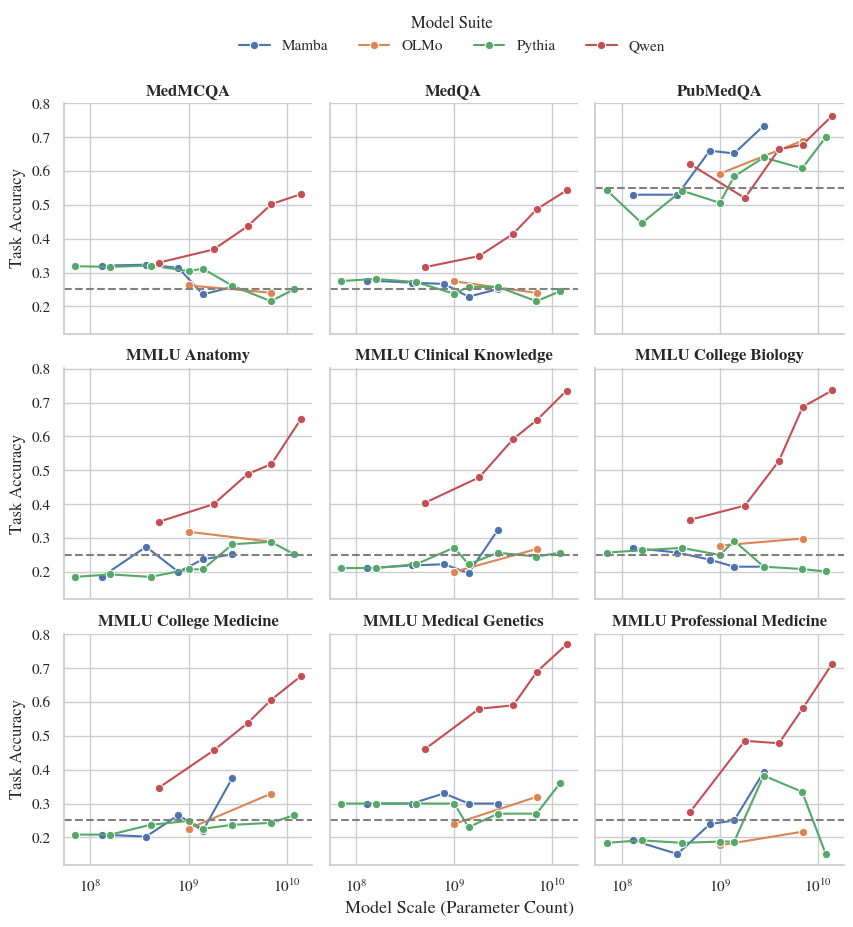

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

scaling_df = pd.read_csv('../eval-results/wandb-logs/cleaned/acc_scale_results.csv')
scaling_df['model_family'] = pd.Categorical(scaling_df['model_family'], categories=sorted(scaling_df['model_family'].unique()), ordered=True)

# Define accuracy columns for the tasks
task_acc_columns = [
    'medmcqa/acc', 'medqa_4options/acc', 'pubmedqa/acc', 'mmlu_anatomy/acc',
    'mmlu_clinical_knowledge/acc', 'mmlu_college_biology/acc',
    'mmlu_college_medicine/acc', 'mmlu_medical_genetics/acc',
    'mmlu_professional_medicine/acc'
]

long_df = scaling_df.melt(id_vars=['param_count', 'model_family'],
                          value_vars=task_acc_columns,
                          var_name='task', value_name='accuracy')

# Setting up the style
sns.set(style="whitegrid", font='STIXGeneral', rc={'axes.spines.bottom': False,
                                                   'axes.spines.left': False,
                                                   'axes.spines.right': False,
                                                   'axes.spines.top': False,
                                                   "font.family": "serif", "font.serif": ["STIXGeneral"]})

# FacetGrid plot
g = sns.FacetGrid(long_df, col='task', hue='model_family', col_wrap=3, height=3, aspect=1)
g.map(sns.lineplot, 'param_count', 'accuracy', marker='o')
g.set(xscale='log')
g.set_axis_labels("", "Task Accuracy")

# Random performance levels
random_perf = {
    'medmcqa/acc': 0.25,
    'medqa_4options/acc': 0.25,
    'pubmedqa/acc': 0.55,
    'mmlu_anatomy/acc': 0.25,
    'mmlu_clinical_knowledge/acc': 0.25,
    'mmlu_college_biology/acc': 0.25,
    'mmlu_college_medicine/acc': 0.25,
    'mmlu_medical_genetics/acc': 0.25,
    'mmlu_professional_medicine/acc': 0.25
}

# Set titles and random performance lines
titles = ["MedMCQA", "MedQA", "PubMedQA", "MMLU Anatomy", "MMLU Clinical Knowledge", "MMLU College Biology", "MMLU College Medicine", "MMLU Medical Genetics", "MMLU Professional Medicine"]
for ax, title, task in zip(g.axes.flat, titles, task_acc_columns):
    ax.set_title(title, weight='bold')
    ax.axhline(y=random_perf[task], color='grey', linestyle='--', label='Random')

g.tight_layout()

plt.subplots_adjust(top=0.9)
#g.fig.suptitle('Zero-Shot Biomedical Performance Across Model Scaling', fontsize=16, weight='bold', x=0.38, y=1.04)
g.fig.text(0.29, 0.0, 'Model Scale (Parameter Count)', fontsize=13)

g.add_legend(title="Model Suite", bbox_to_anchor=(0.37, 0.94), loc='lower center', ncol=4, fancybox=True)

#plt.savefig('../results/figures/acc_across_scale.svg', format='svg')
plt.show()


## Figure 2

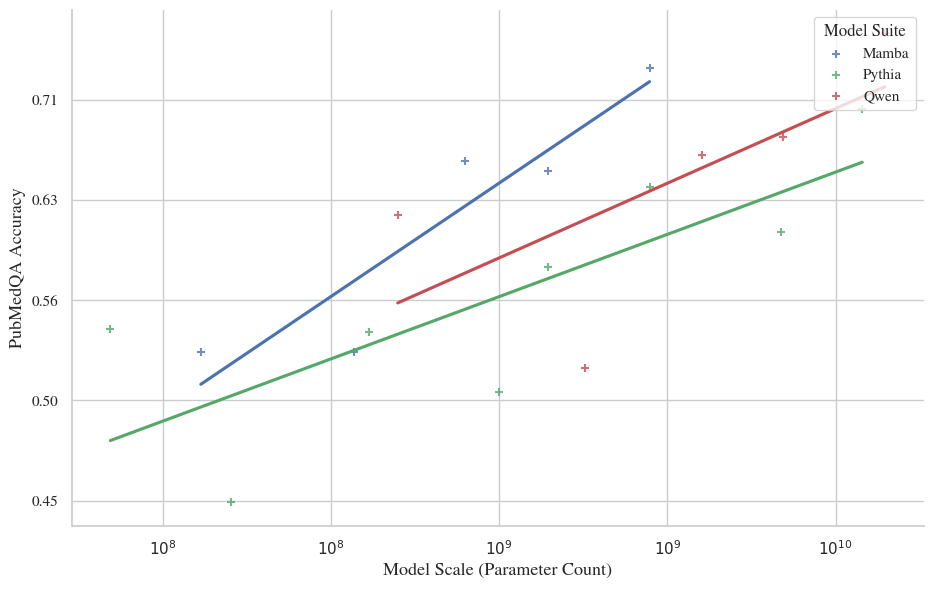

In [3]:
import matplotlib.ticker as ticker

# Calculate the average accuracy for PubMedQA for each model family and parameter count
avg_df = scaling_df.groupby(['param_count', 'model_family'])['pubmedqa/acc'].mean().reset_index()

#remove all olmo models from avg_df
avg_df = avg_df[~avg_df['model_family'].str.contains('OLMo')]

# Apply log transformation to 'param_count' and 'pubmedqa/acc'
avg_df['log_param_count'] = np.log10(avg_df['param_count'])
avg_df['log_pubmedqa_acc'] = np.log10(avg_df['pubmedqa/acc'])

# Create a single plot with regression lines
g = sns.lmplot(data=avg_df, x='log_param_count', y='log_pubmedqa_acc', hue='model_family', height=6, aspect=1.6, legend=False, ci=None, markers="+")

# Set labels
plt.xlabel('Model Scale (Parameter Count)', fontsize=13)
plt.ylabel('PubMedQA Accuracy', fontsize=13)

# Add legend
plt.legend(title="Model Suite", bbox_to_anchor=(1, 1), loc='upper right', ncol=1, fancybox=True)

# Create a function that converts log scale back to original scale
def exp_formatter(x, pos):
    return r'$10^{{{}}}$'.format(int(x))

def exp_formatter_y(y, pos):
    return f'{10**y:.2f}'
# Apply the custom formatter to the x-axis
g.ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter))
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter_y))

#plt.savefig('../analysis-results/figures/loglog_regression_pubmed_acc.svg', format='svg')

plt.show()

## Figure 3

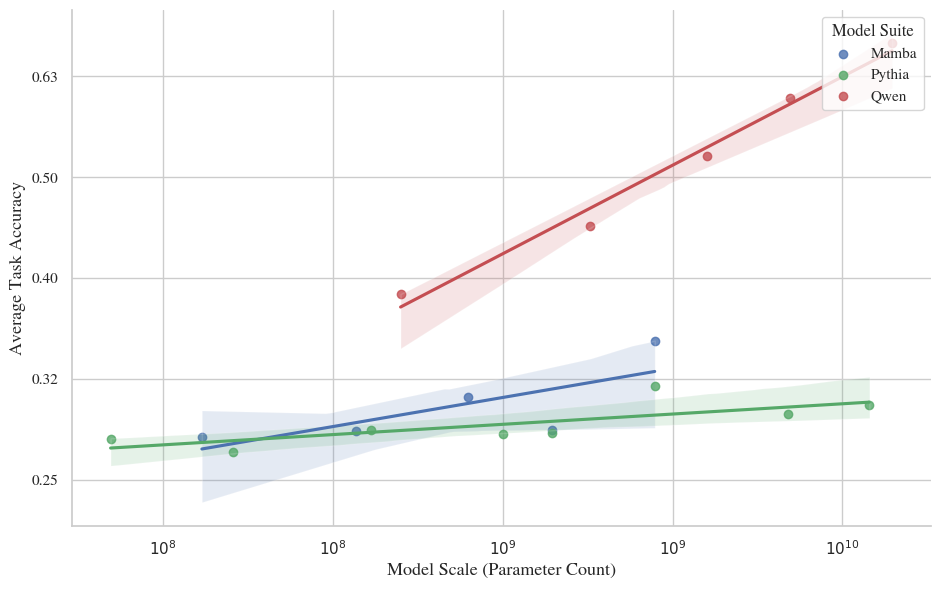

In [5]:

# Calculate the average accuracy across tasks for each model family and parameter count
avg_df = scaling_df.groupby(['param_count', 'model_family'])[task_acc_columns].mean().mean(axis=1).reset_index()
avg_df.columns = ['param_count', 'model_family', 'accuracy']

#remove all olmo models from avg_df
avg_df = avg_df[~avg_df['model_family'].str.contains('OLMo')]


# Apply log transformation to 'param_count' and 'accuracy'
avg_df['log_param_count'] = np.log10(avg_df['param_count'])
avg_df['log_accuracy'] = np.log10(avg_df['accuracy'])

# Create a single plot with regression lines
g = sns.lmplot(data=avg_df, x='log_param_count', y='log_accuracy', hue='model_family', height=6, aspect=1.6, legend=False)

# Set labels
plt.xlabel('Model Scale (Parameter Count)', fontsize=13)
plt.ylabel('Average Task Accuracy', fontsize=13)

# Add title


# Add legend
plt.legend(title="Model Suite", bbox_to_anchor=(1, 1), loc='upper right', ncol=1, fancybox=True)

# Create a function that converts log scale back to original scale
def exp_formatter(x, pos):
    return r'$10^{{{}}}$'.format(int(x))

def exp_formatter_y(y, pos):
    return f'{10**y:.2f}'
# Apply the custom formatter to the x-axis
g.ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter))
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter_y))

#plt.savefig('../analysis-results/figures/loglog_regression_avg_acc.svg', format='svg')

# Show the plot
plt.show()

## Figure 4

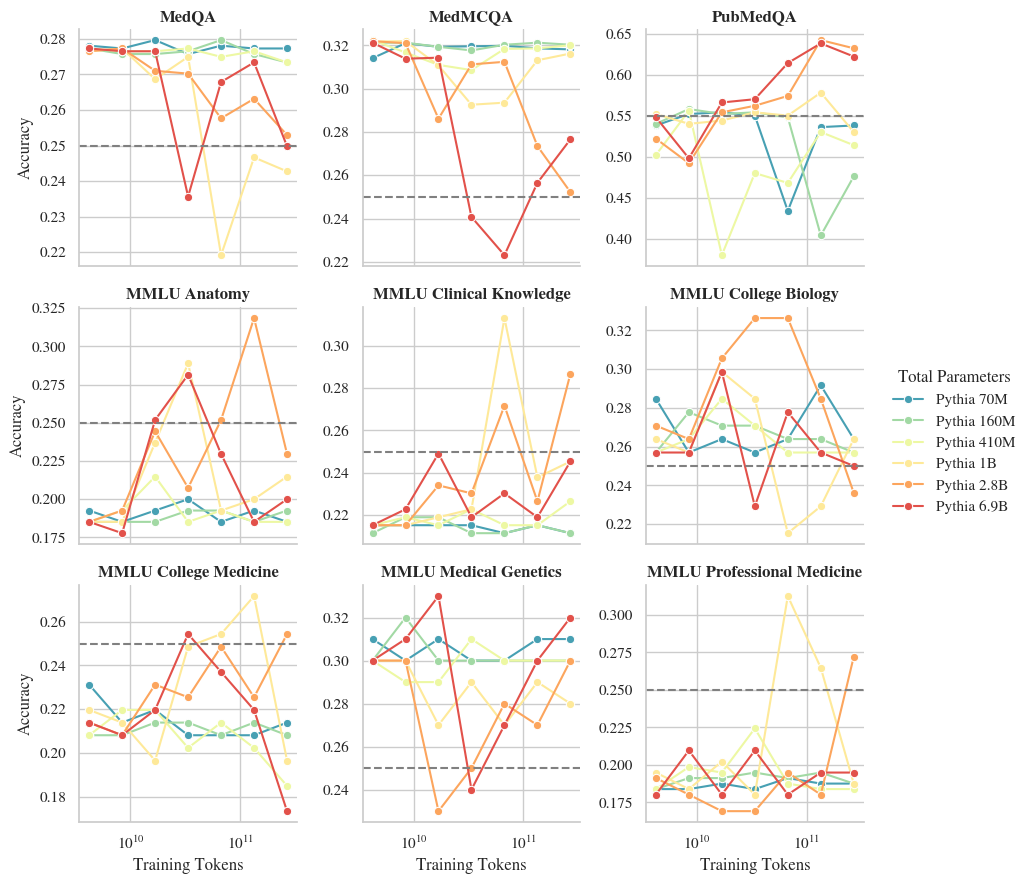

In [8]:

def exp_formatter(x, pos):
    return r'$10^{{{}}}$'.format(int(x))

# Load and prepare data
def load_and_prepare_data(file_paths, model_names):
    all_data = []
    tokens_per_step = 2097152
    for file_path, model_name in zip(file_paths, model_names):
        df = pd.read_csv(file_path)
        if 'Name' in df.columns:
            df['Step'] = df['Name'].str.extract('(\d+)').astype('int64')
        df['Model'] = model_name
        accuracy_columns = [col for col in df.columns if '/acc' in col]
        relevant_columns = ['Step', 'Model'] + accuracy_columns
        df = df[relevant_columns]
        df['tokens_seen'] = df['Step'] * tokens_per_step
        all_data.append(df)
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df['Log10_Step'] = np.log10(combined_df['Step'])
    combined_df['Log10_tokens_seen'] = np.log10(combined_df['tokens_seen'])
    return combined_df

file_paths = [
    "../eval-results/wandb-logs/wandb_pythia_70m_dynamics.csv",
    "../eval-results/wandb-logs/wandb_pythia_160m_dynamics.csv",
    "../eval-results/wandb-logs/wandb_pythia_410m_dynamics.csv",
    "../eval-results/wandb-logs/wandb_pythia_1b_dynamics.csv",
    "../eval-results/wandb-logs/wandb_pythia_2-8b_dynamics.csv",
    "../eval-results/wandb-logs/wandb_pythia_6-9b_dynamics.csv"
]
model_names = ["Pythia 70M", "Pythia 160M", "Pythia 410M", "Pythia 1B", "Pythia 2.8B", "Pythia 6.9B"]

combined_df = load_and_prepare_data(file_paths, model_names)

# Melting DataFrame
task_names = [
    "medqa_4options/acc", "medmcqa/acc", "pubmedqa/acc", "mmlu_anatomy/acc", "mmlu_clinical_knowledge/acc",
    "mmlu_college_biology/acc", "mmlu_college_medicine/acc", "mmlu_medical_genetics/acc", "mmlu_professional_medicine/acc"
]
melted_df = combined_df.melt(id_vars=['tokens_seen', 'Model'], value_vars=task_names, var_name='Task', value_name='Accuracy')

# Reorder the DataFrame based on model size
model_order = ["Pythia 70M", "Pythia 160M", "Pythia 410M", "Pythia 1B", "Pythia 2.8B", "Pythia 6.9B"]
melted_df['Model'] = pd.Categorical(melted_df['Model'], categories=model_order, ordered=True)

# Plot setup
sns.set(style="whitegrid", font='STIXGeneral')

# Defining colors
palette = sns.color_palette("Spectral", len(model_names))
palette.reverse()

# Creating the FacetGrid
g = sns.FacetGrid(melted_df, col='Task', hue='Model', col_wrap=3, height=3, aspect=1, sharey=False, palette=palette)
g.map(sns.lineplot, 'tokens_seen', 'Accuracy', marker='o')
g.set_titles("{col_name}", weight='bold')
g.set_axis_labels("Training Tokens", "Accuracy")
g.set(xscale='log')

# Enabling each subplot to set its own y-axis limits
for ax in g.axes:
    ax.autoscale_view()




random_perf = {
    'medmcqa/acc': 0.25,
    'medqa_4options/acc': 0.25,
    'pubmedqa/acc': 0.55,
    'mmlu_anatomy/acc': 0.25,
    'mmlu_clinical_knowledge/acc': 0.25,
    'mmlu_college_biology/acc': 0.25,
    'mmlu_college_medicine/acc': 0.25,
    'mmlu_medical_genetics/acc': 0.25,
    'mmlu_professional_medicine/acc': 0.25
}




# Set titles and random performance lines
titles = ["MedQA", "MedMCQA", "PubMedQA", "MMLU Anatomy", "MMLU Clinical Knowledge", "MMLU College Biology", "MMLU College Medicine", "MMLU Medical Genetics", "MMLU Professional Medicine"]
for ax, title, task in zip(g.axes.flat, titles, task_names):
    ax.set_title(title, weight='bold')
    ax.axhline(y=random_perf[task], color='grey', linestyle='--', label='Random')
    

g.add_legend(title="Total Parameters", loc='center right', fancybox=True)
g.tight_layout()

#plt.savefig('../analysis-results/figures/dynamics-pythia.svg', format='svg')

plt.show()


## Figure 5

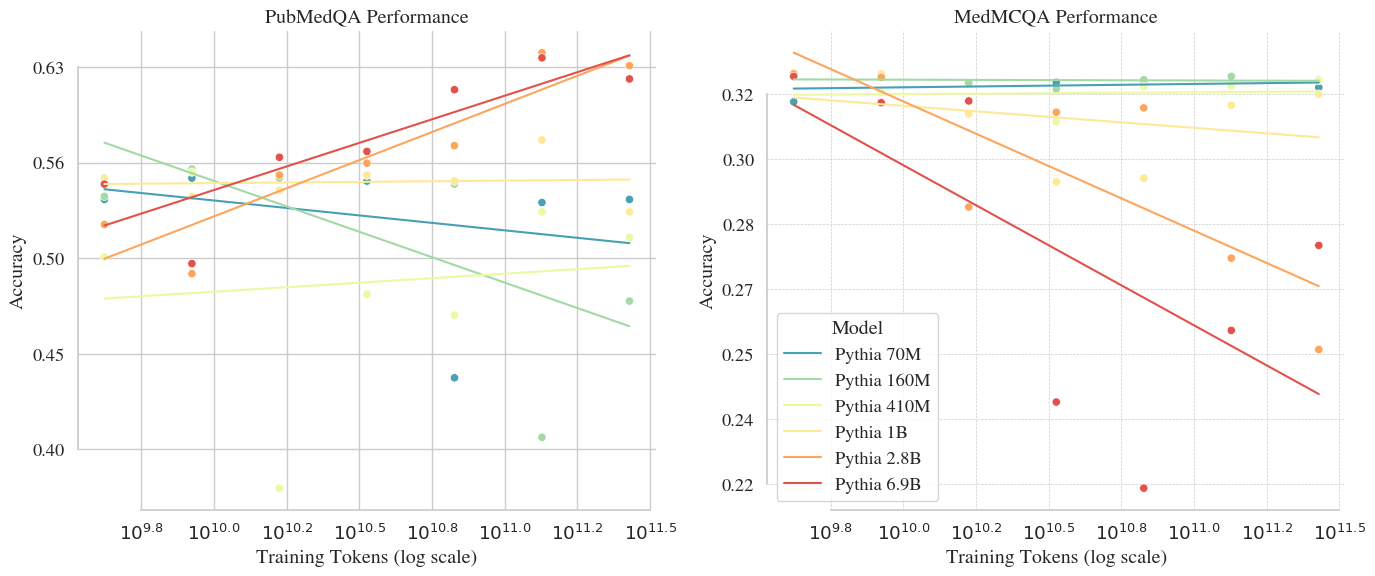

In [10]:

import statsmodels.api as sm

# Create a dictionary to map model names to their parameter sizes
param_sizes = {
    "Pythia 70M": 70000000,
    "Pythia 160M": 160000000,
    "Pythia 410M": 410000000,
    "Pythia 1B": 1000000000,
    "Pythia 2.8B": 28000000000,
    "Pythia 6.9B": 69000000000
}

# Create a new column for parameter size
melted_df['ParamSize'] = melted_df['Model'].map(param_sizes).astype('int64')

# Take the log10 of the parameter size and training steps
melted_df['Log10_ParamSize'] = np.log10(melted_df['ParamSize'])
# Take the log10 of the tokens seen
melted_df['Log10_TokensSeen'] = np.log10(melted_df['tokens_seen'])

melted_df['Log10_Accuracy'] = np.log10(melted_df['Accuracy'])




pubmedqa_data = melted_df[melted_df['Task'] == 'pubmedqa/acc']
medmcqa_data = melted_df[melted_df['Task'] == 'medmcqa/acc']


# Set up the plotting environment
sns.set(style="whitegrid", font_scale=1.2, font='STIXGeneral')
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Define custom log formatter
def exp_formatter(x, pos):
    return r'$10^{{{:.1f}}}$'.format(x)

def exp_formatter_y(y, pos):
    return f'{10**y:.2f}'

# Function to plot with regression lines
def plot_with_regression(data, ax, title, show_legend=True):
    # Setting the palette
    palette = sns.color_palette("Spectral_r", n_colors=len(data['Model'].unique()))
    model_palette = {model: color for model, color in zip(data['Model'].unique(), palette)}
    
    # Scatter plot
    sns.scatterplot(data=data, x='Log10_TokensSeen', y='Log10_Accuracy', hue='Model', 
                    palette=model_palette, marker='o', ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('Training Tokens (log scale)')
    ax.set_ylabel('Accuracy')

    # Adding regression lines for each model
    for model, color in model_palette.items():
        subset = data[data['Model'] == model]
        x = sm.add_constant(subset['Log10_TokensSeen'])
        y = subset['Log10_Accuracy']
        res = sm.OLS(y, x).fit()
        ax.plot(subset['Log10_TokensSeen'], res.predict(x), color=color, label=model, linestyle='solid')

    # Setting custom formatters for log scale
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter_y))

    # Handling legends separately to ensure proper color matching
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Model')

# Plotting the data
plot_with_regression(pubmedqa_data, axs[0], 'PubMedQA Performance', show_legend=False)
plot_with_regression(medmcqa_data, axs[1], 'MedMCQA Performance', show_legend=True)

# Enhance layout
sns.despine(trim=True)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()

# Save the plot as SVG
#plt.savefig('../analysis-results/figures/combined_performance.svg', format='svg')

# Show the plot
plt.show()


## Figure 6

C:\Users\Nikol\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Nikol\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


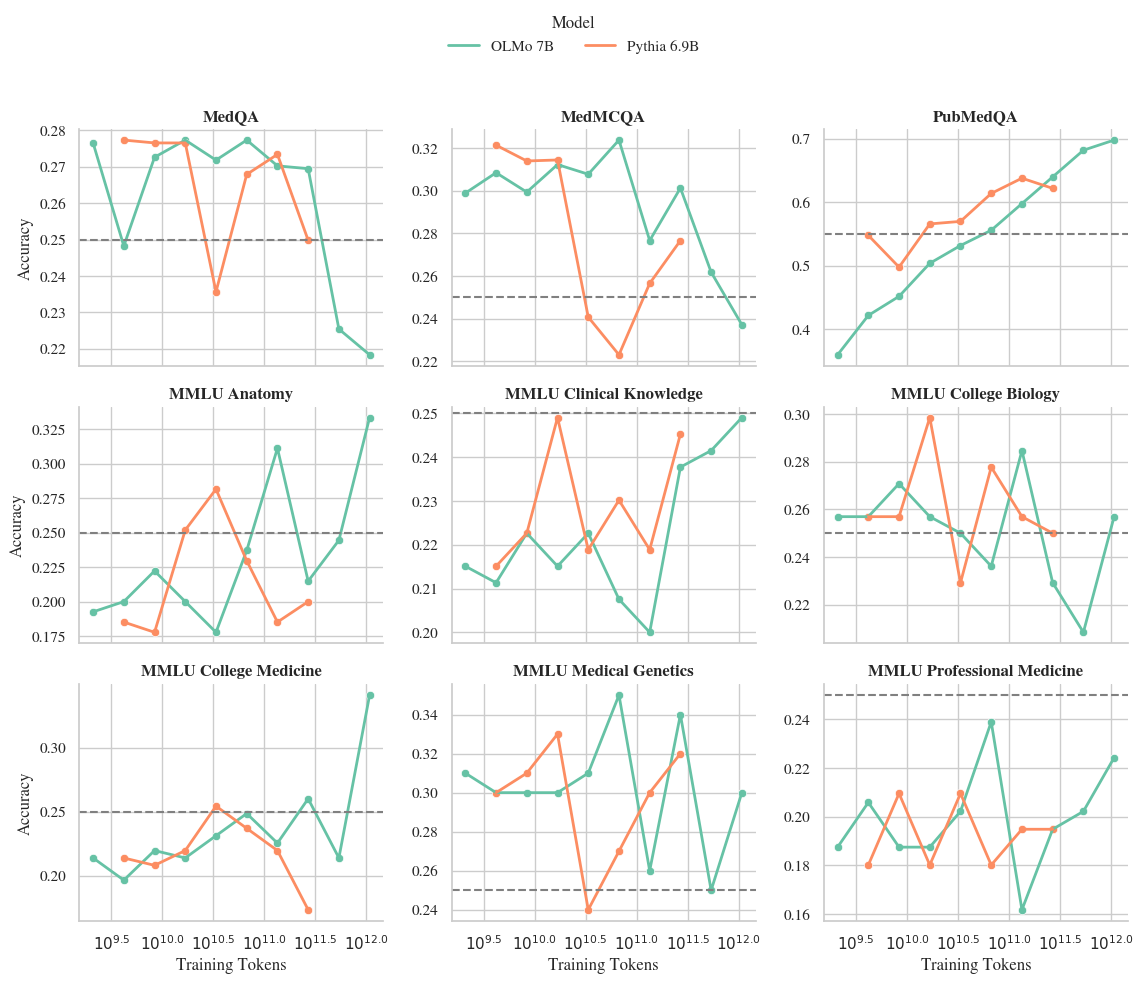

In [12]:
#Olmo v pythia

file_olmo = "../eval-results/wandb-logs/wandb_OLMo7B_dynamics.csv"
file_pythia = "../eval-results/wandb-logs/wandb_pythia_6-9b_dynamics.csv"

# Reading the data
olmo_df = pd.read_csv(file_olmo)
pythia_df = pd.read_csv(file_pythia)

# Extracting the step number and selecting only accuracy-related columns
olmo_df['Step'] = olmo_df['Name'].str.extract('(\d+)').astype('int64')
pythia_df['Step'] = pythia_df['Name'].str.extract('(\d+)').astype('int64')


olmo_df['Model'] = 'OLMo 7B'
pythia_df['Model'] = 'Pythia 6.9B'

# Define the accuracy columns to be selected (based on the user's previous example)
accuracy_columns = [
    "medqa_4options/acc", "medmcqa/acc", "pubmedqa/acc", "mmlu_anatomy/acc", "mmlu_clinical_knowledge/acc",
    "mmlu_college_biology/acc", "mmlu_college_medicine/acc", "mmlu_medical_genetics/acc", "mmlu_professional_medicine/acc"
]

# Filter the dataframes
olmo_relevant = olmo_df[['Step', 'Model'] + accuracy_columns]
pythia_relevant = pythia_df[['Step', 'Model'] + accuracy_columns]

# Combine the dataframes
combined_df = pd.concat([olmo_relevant, pythia_relevant], ignore_index=True)

# Melt the dataframe for visualization
melted_df = combined_df.melt(id_vars=['Step', 'Model'], value_vars=accuracy_columns, var_name='Task', value_name='Accuracy')



# Convert 'Step' to log10 scale for better visualization
melted_df['Log10_Step'] = np.log10(melted_df['Step'])

tokens_per_step = 2097152

melted_df['tokens_seen'] = melted_df['Step'] * tokens_per_step
       
melted_df['Log10_tokens_seen'] = np.log10(melted_df['tokens_seen'])

# Set up the seaborn style
sns.set(style="whitegrid", font='STIXGeneral')

# Defining the color palette
palette = sns.color_palette("Set2", 2)  # One color for each model

# Creating the FacetGrid for scatter plots
g = sns.FacetGrid(melted_df, col='Task', hue='Model', col_wrap=3, height=3, aspect=1, sharey=False, palette=palette)
g.map(sns.scatterplot, 'Log10_tokens_seen', 'Accuracy')
g.map_dataframe(sns.lineplot, 'Log10_tokens_seen', 'Accuracy', errorbar=None, lw=2)


g.set_titles("{col_name}", weight='bold')
g.set_axis_labels("Training Tokens", "Accuracy")

# Adding random performance lines as a reference
random_perf = {
    'medmcqa/acc': 0.25,
    'medqa_4options/acc': 0.25,
    'pubmedqa/acc': 0.55,
    'mmlu_anatomy/acc': 0.25,
    'mmlu_clinical_knowledge/acc': 0.25,
    'mmlu_college_biology/acc': 0.25,
    'mmlu_college_medicine/acc': 0.25,
    'mmlu_medical_genetics/acc': 0.25,
    'mmlu_professional_medicine/acc': 0.25
}

def exp_formatter(x, pos):
    return r'$10^{{{:.1f}}}$'.format(x)

# Set titles and random performance lines
titles = ["MedQA", "MedMCQA", "PubMedQA", "MMLU Anatomy", "MMLU Clinical Knowledge", "MMLU College Biology", "MMLU College Medicine", "MMLU Medical Genetics", "MMLU Professional Medicine"]
for ax, title, task in zip(g.axes.flat, titles, accuracy_columns):
    ax.set_title(title, weight='bold')
    ax.axhline(y=random_perf[task], color='grey', linestyle='--', label='Random')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_formatter))

# Add legends and adjust layout
g.add_legend(title="Model", loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.tight_layout()

#plt.savefig('../analysis-results/figures/olmo_vs_pythia.svg', format='svg')


plt.show()


## Figure 7

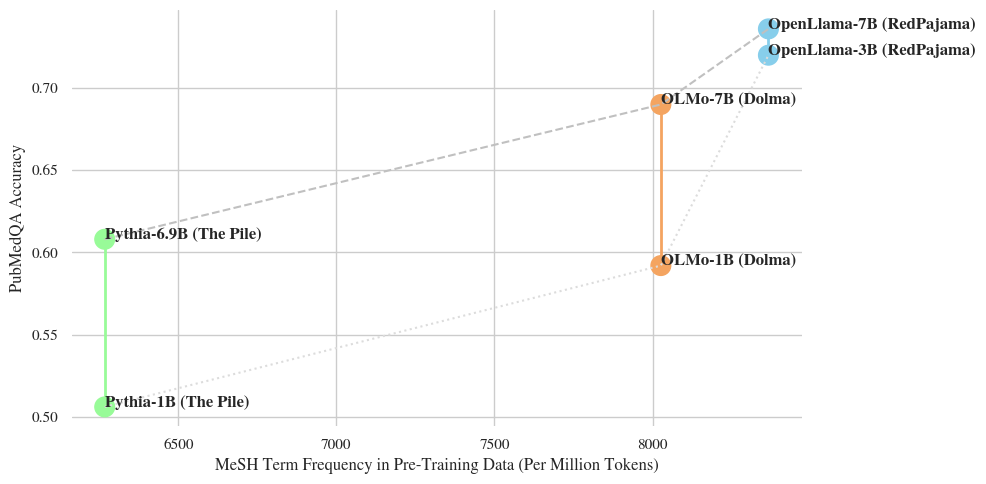

In [13]:

# Data setup
data1 = pd.DataFrame({
    'Corpus': ['OLMo-7B (Dolma)', 'Pythia-6.9B (The Pile)', 'OpenLlama-7B (RedPajama)'],
    'Normalized_MeSH_Count': [8026.2, 6267.2, 8366.4], #Numbers manually extracted from the calculations in tables.ipynb
    'PubMedQA_Accuracy': [0.69, 0.608, 0.736] #Numers manually extracted from the wandb logs
})

data2 = pd.DataFrame({
    'Corpus': ['OLMo-1B (Dolma)', 'Pythia-1B (The Pile)', 'OpenLlama-3B (RedPajama)'],
    'Normalized_MeSH_Count': [8026.2, 6267.2, 8366.4], #Numbers manually extracted from the calculations in tables.ipynb
    'PubMedQA_Accuracy': [0.592, 0.506, 0.72 ]#Numbers manually extracted from the wandb logs
})

# Combine the dataframes and reset the index
data = pd.concat([data1, data2]).reset_index(drop=True)

colors = ['sandybrown', 'palegreen', 'skyblue', 'sandybrown', 'palegreen', 'skyblue']

# Create a dictionary that maps each unique x-coordinate to a color
color_dict = {x: color for x, color in zip(data['Normalized_MeSH_Count'].unique(), colors)}

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(data['Normalized_MeSH_Count'], data['PubMedQA_Accuracy'], c=colors, s=200, alpha=1)
plt.xlabel('MeSH Term Frequency in Pre-Training Data (Per Million Tokens)')
plt.ylabel('PubMedQA Accuracy')
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add vertical lines
for x, color in color_dict.items():
    y_values = data[data['Normalized_MeSH_Count'] == x]['PubMedQA_Accuracy']
    plt.vlines(x, min(y_values), max(y_values), colors=color, linestyles='solid', lw=2)

# Add lines connecting specific points
corpus_order = ['Pythia-6.9B (The Pile)', 'OLMo-7B (Dolma)', 'OpenLlama-7B (RedPajama)', 'Pythia-1B (The Pile)', 'OLMo-1B (Dolma)', 'OpenLlama-3B (RedPajama)']
x_values = [data[data['Corpus'] == corpus]['Normalized_MeSH_Count'].values[0] for corpus in corpus_order]
y_values = [data[data['Corpus'] == corpus]['PubMedQA_Accuracy'].values[0] for corpus in corpus_order]
plt.plot(x_values[:3], y_values[:3], color='silver', linestyle='--')  # Line connecting Pythia-6.9B, OLMo-7B, OpenLlama-7B
plt.plot(x_values[3:], y_values[3:], color='gainsboro', linestyle='dotted')  # Line connecting Pythia-1B, OLMo-1B, OpenLlama-3B


for i, txt in enumerate(data['Corpus']):
    plt.annotate(txt, (data['Normalized_MeSH_Count'].iloc[i], data['PubMedQA_Accuracy'].iloc[i]), fontweight='bold')
#plt.savefig('../analysis-results/figures/meshterm_vs_accuracy_combined.svg', format='svg')
plt.tight_layout()
plt.show()

## Figure 8

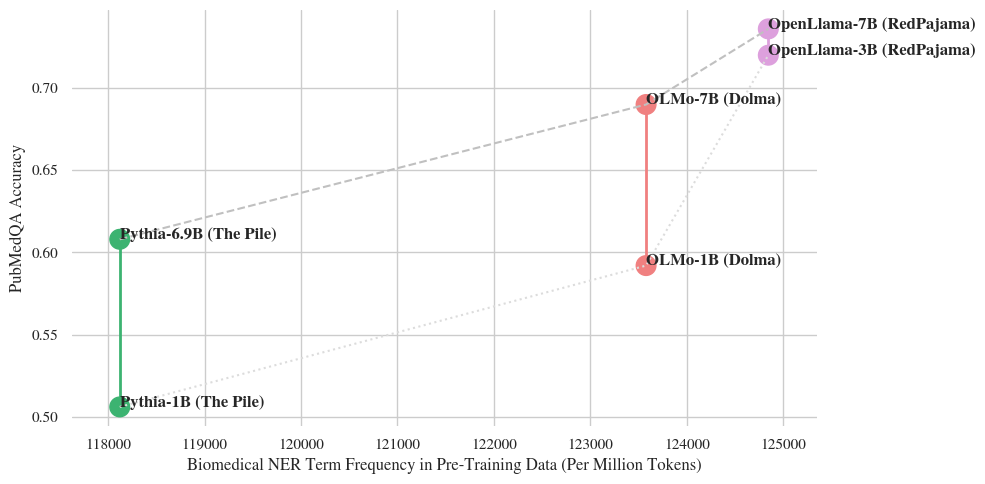

In [14]:

# Data setup
data1 = pd.DataFrame({
    'Corpus': ['OLMo-7B (Dolma)', 'Pythia-6.9B (The Pile)', 'OpenLlama-7B (RedPajama)'],
    'Normalized_NER_Count': [123577.8, 118120.5, 124845.1], #Numbers manually extracted from the calculations in tables.ipynb
    'PubMedQA_Accuracy': [0.69, 0.608, 0.736] #Numers manually extracted from the wandb logs
})

data2 = pd.DataFrame({
    'Corpus': ['OLMo-1B (Dolma)', 'Pythia-1B (The Pile)', 'OpenLlama-3B (RedPajama)'],
    'Normalized_NER_Count': [123577.8, 118120.5, 124845.1], #Numbers manually extracted from the calculations in tables.ipynb
    'PubMedQA_Accuracy': [0.592, 0.506, 0.72] #Numbers manually extracted from the wandb logs
})

# Combine the dataframes and reset the index
data = pd.concat([data1, data2]).reset_index(drop=True)

colors = ['lightcoral', 'mediumseagreen', 'plum','lightcoral', 'mediumseagreen', 'plum']

# Create a dictionary that maps each unique x-coordinate to a color
color_dict = {x: color for x, color in zip(data['Normalized_NER_Count'].unique(), colors)}

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(data['Normalized_NER_Count'], data['PubMedQA_Accuracy'], c=colors, s=200, alpha=1)
plt.xlabel('Biomedical NER Term Frequency in Pre-Training Data (Per Million Tokens)')
plt.ylabel('PubMedQA Accuracy')
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add vertical lines
for x, color in color_dict.items():
    y_values = data[data['Normalized_NER_Count'] == x]['PubMedQA_Accuracy']
    plt.vlines(x, min(y_values), max(y_values), colors=color, linestyles='solid', lw=2)

# Add lines connecting specific points
corpus_order = ['Pythia-6.9B (The Pile)', 'OLMo-7B (Dolma)', 'OpenLlama-7B (RedPajama)', 'Pythia-1B (The Pile)', 'OLMo-1B (Dolma)', 'OpenLlama-3B (RedPajama)']
x_values = [data[data['Corpus'] == corpus]['Normalized_NER_Count'].values[0] for corpus in corpus_order]
y_values = [data[data['Corpus'] == corpus]['PubMedQA_Accuracy'].values[0] for corpus in corpus_order]
plt.plot(x_values[:3], y_values[:3], color='silver', linestyle='--')  # Line connecting Pythia-6.9B, OLMo-7B, OpenLlama-7B
plt.plot(x_values[3:], y_values[3:], color='gainsboro', linestyle='dotted')  # Line connecting Pythia-1B, OLMo-1B, OpenLlama-3B

plt.xlim(min(data['Normalized_NER_Count']) - 500, max(data['Normalized_NER_Count']) + 500)

for i, txt in enumerate(data['Corpus']):
    plt.annotate(txt, (data['Normalized_NER_Count'].iloc[i], data['PubMedQA_Accuracy'].iloc[i]), fontweight='bold')
#plt.savefig('../analysis-results/figures/nerterm_vs_accuracy_combined.svg', format='svg')
plt.tight_layout()
plt.show()

## Figure 9

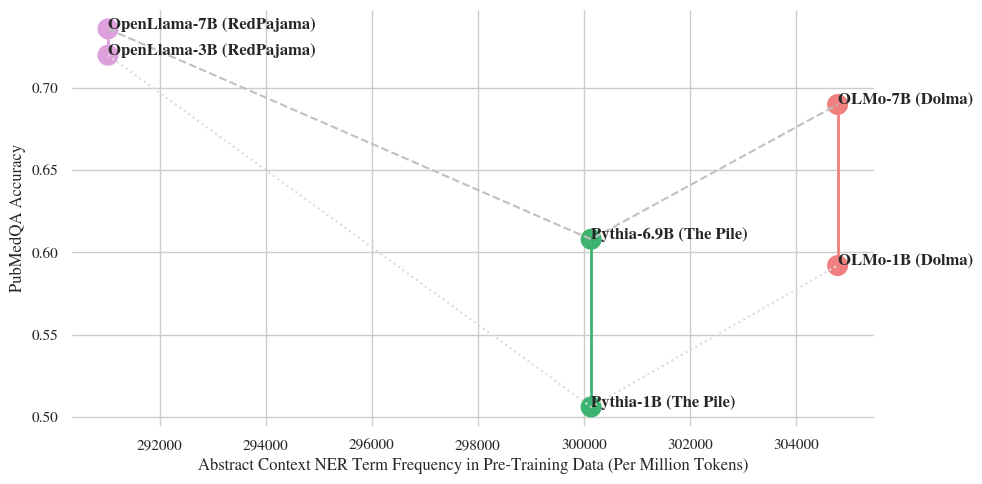

In [15]:

# Data setup
data1 = pd.DataFrame({
    'Corpus': ['OLMo-7B (Dolma)', 'Pythia-6.9B (The Pile)', 'OpenLlama-7B (RedPajama)'],
    'Normalized_Context_Count': [304777.5, 300133.4, 291029.7], #Numbers manually extracted from the calculations in tables.ipynb
    'PubMedQA_Accuracy': [0.69, 0.608, 0.736] #Numers manually extracted from the wandb logs
})

data2 = pd.DataFrame({
    'Corpus': ['OLMo-1B (Dolma)', 'Pythia-1B (The Pile)', 'OpenLlama-3B (RedPajama)'],
    'Normalized_Context_Count': [304777.5, 300133.4, 291029.7], #Numbers manually extracted from the calculations in tables.ipynb
    'PubMedQA_Accuracy': [0.592, 0.506, 0.72]   #Numers manually extracted from the wandb logs
})

# Combine the dataframes and reset the index
data = pd.concat([data1, data2]).reset_index(drop=True)

colors = ['lightcoral', 'mediumseagreen', 'plum','lightcoral', 'mediumseagreen', 'plum']

# Create a dictionary that maps each unique x-coordinate to a color
color_dict = {x: color for x, color in zip(data['Normalized_Context_Count'].unique(), colors)}

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(data['Normalized_Context_Count'], data['PubMedQA_Accuracy'], c=colors, s=200, alpha=1)
plt.xlabel('Abstract Context NER Term Frequency in Pre-Training Data (Per Million Tokens)')
plt.ylabel('PubMedQA Accuracy')
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add vertical lines
for x, color in color_dict.items():
    y_values = data[data['Normalized_Context_Count'] == x]['PubMedQA_Accuracy']
    plt.vlines(x, min(y_values), max(y_values), colors=color, linestyles='solid', lw=2)

# Add lines connecting specific points
corpus_order = ['OpenLlama-7B (RedPajama)','Pythia-6.9B (The Pile)','OLMo-7B (Dolma)', 'OpenLlama-3B (RedPajama)','Pythia-1B (The Pile)', 'OLMo-1B (Dolma)']
x_values = [data[data['Corpus'] == corpus]['Normalized_Context_Count'].values[0] for corpus in corpus_order]
y_values = [data[data['Corpus'] == corpus]['PubMedQA_Accuracy'].values[0] for corpus in corpus_order]
plt.plot(x_values[:3], y_values[:3], color='silver', linestyle='--')  # Line connecting Pythia-6.9B, OLMo-7B, OpenLlama-7B
plt.plot(x_values[3:], y_values[3:], color='gainsboro', linestyle='dotted')  # Line connecting Pythia-1B, OLMo-1B, OpenLlama-3B



for i, txt in enumerate(data['Corpus']):
    plt.annotate(txt, (data['Normalized_Context_Count'].iloc[i], data['PubMedQA_Accuracy'].iloc[i]), fontweight='bold')
#plt.savefig('../analysis-results/figures/context_nerterm_vs_accuracy_combined.svg', format='svg')
plt.tight_layout()
plt.show()